# QR Code Reader

### Understanding QR Codes

QR codes (short for Quick Response Codes) were invented in 1994, by the DENSO Corporation. These codes store data in two dimensions in the form of an array of contrasting regions. The information density of a QR code is much higher than a vanilla barcode; depending on the format used and the resolution of reader, over a thousand bytes can be encoded in a region the size of a postage stamp.

QR codes use a Reed–Solomon error correction based technology to help recover from errors in reading (for instance, caused by a smudge, badly printed code or other deformity).

Any QR code can be broken into the following sections:

<div style="width:75%;text-align:center;"><img src="Images/formatting.jpg" width=100%></div>

On three corners of a QR code are square blocks that the reader uses to coarsely identify and then align the code. These will be of primary interest during the lab. Once these corners are identified and the image is aligned, the size of the QR code is determined by the timing information which alternates from black and white in both the vertical and horizontal direction. 

Once the image is aligned and the size determined, the QR code is discretized, undergoes an Xor with a particular mask given the format information, and read bit for bit in the following order:

<div style="width:75%;text-align:center;"><img src="Images/decoding.jpg" width=100%></div>

For more details about the decoding process, see the [DataGenetics Wounded QR Codes Blog](http://datagenetics.com/blog/november12013/index.html).

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from decoder import decode

### Finding Corners

QR codes are designed with a very specific pattern so that can efficiently be detected, oriented, and decoded. The first step to detecting a QR code is finding the position markers that are always present in three of the four corners. These position markers always have a black/white/black/white/black ratio of 1:1:3:1:1, no matter the angle they are approached from.

We will find these locations where the ratio of 1:1:3:1:1 is present and mark the center of the position/orientation boxes.

In [46]:
def look4Ratios(lst):
    """Tests whether the given list has any 1:1:3:1:1 ratios with some tolerance"""
    res = []
    tol = 4
    for i in range(0,len(lst)-4,2):
        unitSize = lst[i]
        if abs(lst[i] - unitSize) < tol:
            if abs(lst[i+1] - unitSize) < tol:
                if abs(lst[i+4] - unitSize) < tol:
                    if abs(lst[i+3] - unitSize) < tol:
                        if abs(lst[i+2]/3 - unitSize) < tol:
                            res.append(i)
    return res

def findMatches(row):
    ratioList = []
    idxList = []
    willStart = False
    looking4black = True
    count = 0
    padding = 0
    for j in range(len(row)):
        if not willStart:            #ensures that we don't start counting until we find a black point
            if row[j] == 0:
                idxList.append(j)
                willStart = True
                count+=1
            else:
                padding+=1          #But the padding keeps track of if the picture starts with whitespace
        else:
            if looking4black:
                if row[j] == 0:
                    count +=1
                else:
                    ratioList.append(count)
                    idxList.append(j)
                    looking4black = False
                    count = 1
            else:
                if row[j] == 1:
                    count +=1
                else:
                    ratioList.append(count)
                    idxList.append(j)
                    looking4black = True
                    count = 1
    ratioList.append(count)
    return ratioList,idxList,padding



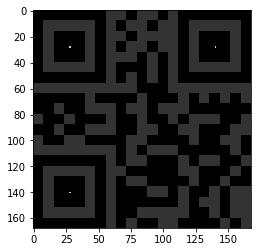

In [6]:
img = cv2.imread("./QR_codes/Basic.png",cv2.IMREAD_GRAYSCALE)
plt.imshow(img,'gray')
corners = []
accumulator = np.zeros_like(img)
threshold = 200
skip = 5
for i in range(0,len(img[0])):             #Vertically looping
    col = np.copy(img[:,i])
    col[col < threshold] = 0
    col[col >= threshold] = 1
    ratioList,idxList,padding = findMatches(col)
    res = look4Ratios(ratioList)
    if len(res) == 0:                        #if we find no possible locations, move to the next line
        continue
    for x in res:
        length = np.sum(ratioList[x+2:x+3])
        locStart = np.sum(ratioList[:x+2])
        accumulator[locStart+length//2,i] += 1

for i in range(0,len(img)):                #horizontally looping
    row = np.copy(img[i])
    row[row < threshold] = 0
    row[row >= threshold] = 1
    ratioList,idxList,padding = findMatches(row)
    res = look4Ratios(ratioList)
    if len(res) == 0:                        #if we find no possible locations, move to the next line
        continue
    for x in res:
        length = np.sum(ratioList[x+2:x+3])
        locStart = np.sum(ratioList[:x+2])
        accumulator[i,locStart+length//2] += 1

accumulator[accumulator<2]=0
accumulator[accumulator>1]=255
    
plt.imshow(accumulator,'gray',alpha=0.8)
            
plt.show()

        

### Finding The Fourth Point and Aligning with a Homography

QR codes only contain three known corner points, but homographies require four points to be defined. This is fixed easily enough as the distance between the positioning/orientation boxes is the same. So all we need to do is place a point that same distance away from the bottom box. Once we have warped the box, we will crop the picture to fit

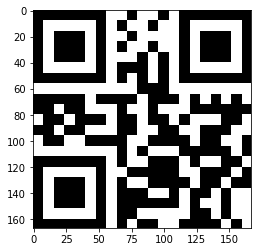

In [7]:
centers = np.nonzero(accumulator)                     #get the 4 points and use opencv to find the homography and warp it
distance12 = (abs(centers[0][0]-centers[0][1]),abs(centers[1][0]-centers[1][1]))
xs = np.append(centers[0],centers[0][2]+distance12[0])
ys = np.append(centers[1],centers[1][2]+distance12[1])
src = np.array([[xs[i],ys[i]] for i in range(len(xs))])

l = int(np.linalg.norm(distance12))


h, status = cv2.findHomography(src,np.array([[l,l],[l, 2*l],[2*l, l],[2*l,2*l]]))
alignedImg = cv2.warpPerspective(img, h, (3*l,3*l))

boundingCoords = []                                    #Now we just have to find the bounding coordinates and crop
for x in range(len(alignedImg)):
    if len(np.nonzero(alignedImg[x])[0]) > 0:
        boundingCoords.append(x)
        break

for x in reversed(range(len(alignedImg))):
    if len(np.nonzero(alignedImg[x])[0]) > 0:
        boundingCoords.append(x)
        break
        
for y in range(len(alignedImg[0])):
    if len(np.nonzero(alignedImg[:,y])[0]) > 0:
        boundingCoords.append(y)
        break
for y in reversed(range(len(alignedImg[0]))):
    if len(np.nonzero(alignedImg[:,y])[0]) > 0:
        boundingCoords.append(y)
        break

croppedImg = alignedImg[boundingCoords[0]:boundingCoords[1],boundingCoords[2]:boundingCoords[3]]        
plt.imshow(croppedImg,'gray')
plt.show()

### Discretization

Now that the image is aligned, the QR code needs to discretized so that each block is a single bit, rather than a group of pixels. Using OpenCV's resize method, this becomes as easy as checking to see if the timing information is still valid. See the picture above for details

In [8]:
def testImage(img):
    """Detects the alternating pattern in the timing marks. Returns true if it's the correct pattern"""
    is1 = True
    for i in img[6][7:-7]:
        if is1 and i == 1:
            is1 = False
        elif not is1 and i == 0:
            is1 = True
        else:
            return False
    is1 = True
    for i in img[:,6][7:-7]:
        if is1 and i == 1:
            is1 = False
        elif not is1 and i == 0:
            is1 = True
        else:
            return False
    return True

21


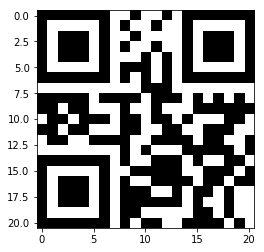

In [9]:
thresh = 100        
for size in range(21,34):                        #we try resizing it to several different sizes and check to see if it worked
    smallImg = cv2.resize(croppedImg,(size,size))
    smallImg[smallImg <= thresh] = 0
    smallImg[smallImg > thresh] = 1
    if testImage(smallImg):
        print(size)
        plt.imshow(smallImg,'gray')
        plt.show()
        break

### Decoding

QR codes are decoded using a very particular block pattern.For simplicity, we put this decoder in a separate file called decoder.py. To use it, simply call `decode()` from the decoder.py file and feed it your 2D Numpy array. It will return a string with the QR code data.

**Note: You may need to run** `conda install beautifulsoup4` **and** `conda install requests` **to get the decoder to run.**

In [10]:
output = decode(smallImg)
print(output)

http://byu.edu


# Full Program

In [17]:
def look4Ratios(lst):
    res = []
    tol = 2
    for i in range(0,len(lst)-4,2):
        unitSize = lst[i]
        if abs(lst[i] - unitSize) < tol:
            if abs(lst[i+1] - unitSize) < tol:
                if abs(lst[i+4] - unitSize) < tol:
                    if abs(lst[i+3] - unitSize) < tol:
                        if abs(lst[i+2]/3 - unitSize) < tol:
                            res.append(i)
    return res

def findMatches(row):
    ratioList = []
    idxList = []
    willStart = False
    looking4black = True
    count = 0
    padding = 0
    for j in range(len(row)):
        if not willStart:            #ensures that we don't start counting until we find a black point
            if row[j] == 0:
                idxList.append(j)
                willStart = True
                count+=1
            else:
                padding+=1
        else:
            if looking4black:
                if row[j] == 0:
                    count +=1
                else:
                    ratioList.append(count)
                    idxList.append(j)
                    looking4black = False
                    count = 1
            else:
                if row[j] == 1:
                    count +=1
                else:
                    ratioList.append(count)
                    idxList.append(j)
                    looking4black = True
                    count = 1
    ratioList.append(count)
    return ratioList,idxList,padding

def testImage(img):
    is1 = True
    for i in img[6][7:-7]:
        if is1 and i == 1:
            is1 = False
        elif not is1 and i == 0:
            is1 = True
        else:
            return False
    is1 = True
    for i in img[:,6][7:-7]:
        if is1 and i == 1:
            is1 = False
        elif not is1 and i == 0:
            is1 = True
        else:
            return False
    return True

def QRReader(img):
    corners = []
    accumulator = np.zeros_like(img)
    threshold = 150
    img[img < threshold] = 0
    img[img >= threshold] = 1
    for i in range(0,len(img[0])):             #Vertically looping
        col = np.copy(img[:,i])
        ratioList,idxList,padding = findMatches(col)
        res = look4Ratios(ratioList)
        
        if len(res) == 0:                        #if we find no possible locations, move to the next line
            continue
        for x in res:
            length = np.sum(ratioList[x+2:x+3])
            locStart = padding+np.sum(ratioList[:x+2])
            accumulator[locStart+length//2,i] += 1
#             locEnd = padding+np.sum(ratioList[:x+3])
#             accumulator[locStart:locEnd,i] +=1

    for i in range(0,len(img)):                #horizontally looping
        row = np.copy(img[i])
        ratioList,idxList,padding = findMatches(row)
        res = look4Ratios(ratioList)
        if len(res) == 0:                        #if we find no possible locations, move to the next line
            continue
        for x in res:
            length = np.sum(ratioList[x+2:x+3])
            locStart = padding+np.sum(ratioList[:x+2])
            accumulator[i,locStart+length//2] += 1
#             locEnd = padding+np.sum(ratioList[:x+3])
#             accumulator[locStart:locEnd,i] +=1

    accumulator[accumulator<2]=0
    accumulator[accumulator>1]=255
    
    centers = np.nonzero(accumulator)
#     plt.imshow(img,'gray')
#     plt.imshow(accumulator,alpha=0.5)
#     plt.show()
#     print(centers)
    distance12 = (abs(centers[0][0]-centers[0][1]),abs(centers[1][0]-centers[1][1]))
    xs = np.append(centers[0],centers[0][2]+distance12[0])
    ys = np.append(centers[1],centers[1][2]+distance12[1])
    src = np.array([[xs[i],ys[i]] for i in range(len(xs))])

    l = int(np.linalg.norm(distance12))
    img += 1
    img[img>1]=0
#     print("invert")
#     plt.imshow(img,'gray')
#     plt.show()
#     print(l,src)
    h, status = cv2.findHomography(src,np.array([[l,l],[l, 2*l],[2*l, l],[2*l,2*l]]))
#     print(h,status)
    alignedImg = cv2.warpPerspective(img, h, (3*l,3*l))
#     print("align")
#     plt.imshow(alignedImg,'gray')
#     plt.show()
    boundingCoords = []
    
    for x in range(len(alignedImg)):
        if len(np.nonzero(alignedImg[x])[0]) > 0:
            boundingCoords.append(x)
            break

    for x in reversed(range(len(alignedImg))):
        if len(np.nonzero(alignedImg[x])[0]) > 0:
            boundingCoords.append(x)
            break

    for y in range(len(alignedImg[0])):
        if len(np.nonzero(alignedImg[:,y])[0]) > 0:
            boundingCoords.append(y)
            break
    for y in reversed(range(len(alignedImg[0]))):
        if len(np.nonzero(alignedImg[:,y])[0]) > 0:
            boundingCoords.append(y)
            break
#     print(boundingCoords)
    croppedImg = alignedImg[boundingCoords[0]:boundingCoords[1],boundingCoords[2]:boundingCoords[3]]
    croppedImg +=1
    croppedImg[croppedImg>1]=0
    
#     print("Crop")
#     plt.imshow(croppedImg,'gray')
#     plt.show()
    thresh = 1        
    for size in range(21,34):
        smallImg = cv2.resize(croppedImg,(size,size))
        smallImg[smallImg < thresh] = 0
        smallImg[smallImg >= thresh] = 1
        if testImage(smallImg):
#             print(size)
            break
#     print("Shrink")
#     plt.imshow(smallImg,'gray')
#     plt.show()
            
    output = decode(smallImg)
    return output

## Tests


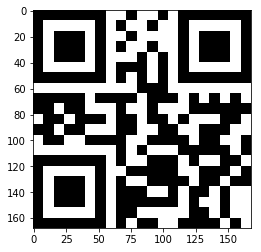

http://byu.edu


In [18]:
img = cv2.imread("./QR_codes/Basic.png",cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap="gray");plt.show()
print(QRReader(img))

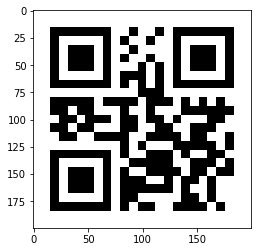

http://byu.edu


In [19]:
image = cv2.imread("QR_codes/test1.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()
print(QRReader(image))

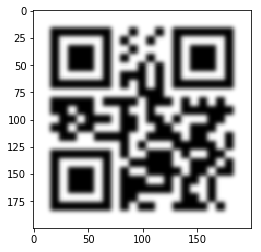

http://byu.edu


In [21]:
image = cv2.imread("QR_codes/test3.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()
print(QRReader(image))

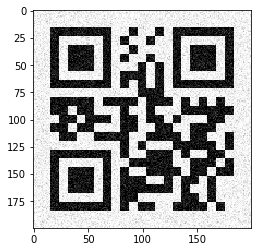

http://byu.edu


In [22]:
image = cv2.imread("QR_codes/test4.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()
print(QRReader(image))

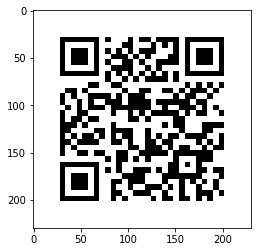

http://DataGenetics.com


In [23]:
image = cv2.imread("QR_codes/test5.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()
print(QRReader(image))